In [1]:
#导入相关包
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
# 使用预训练网络
conv_base = tf.keras.applications.VGG16(weights="imagenet", # 使用该模型image权重
                                        input_shape=(256,256,3), 
                                        include_top = False)
layer_names = [
    "block5_conv3", # 14x14
    "block4_conv3", # 28x28
    "block3_conv3", # 56x56
    "block5_pool"
] # 获取输出层的名字
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]
# 从预训练网络中创建子模型
multi_out_model = tf.keras.models.Model(inputs = conv_base.input,outputs = layers_output)
multi_out_model.trainable = False # 禁止训练

In [3]:
#构建模型
inputs = tf.keras.layers.Input(shape=(256,256,3))
out_block5_conv3,out_block4_conv3,out_block3_conv3,out = multi_out_model(inputs)
#输出512个卷积核 窗口大小3*3   图片变大2倍填充方式same保证和原有图像大小一样  激活relu
x1 = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding="same",activation="relu")(out) # 调用out层
x1 = tf.keras.layers.SpatialDropout2D(0.6)(x1)
x1 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x1) # 在增加一层卷积
x1 = tf.keras.layers.SpatialDropout2D(0.6)(x1)
x2 = tf.add(x1,out_block5_conv3) # 层相加
x2 = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding="same",activation="relu")(x2)
x2 = tf.keras.layers.SpatialDropout2D(0.6)(x2)
x2 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x2) # 在增加一层卷积
x2 = tf.keras.layers.SpatialDropout2D(0.6)(x2)
x3 = tf.add(x2,out_block4_conv3) # 层相加
x3 = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding="same",activation="relu")(x3)
x3 = tf.keras.layers.SpatialDropout2D(0.6)(x3)
x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3) # 在增加一层卷积进一步提取特征
x3 = tf.keras.layers.SpatialDropout2D(0.6)(x3)
x4 = tf.add(x3,out_block3_conv3)
x5 = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding="same",activation="relu")(x4)
x5 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x5) # 在增加一层卷积进一步提取特征
prediction = tf.keras.layers.Conv2DTranspose(5, 3, strides=2,padding="same",activation="softmax")(x5) # 上采样
model1 = tf.keras.models.Model(inputs=inputs,outputs=prediction)

In [4]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 16, 16, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 512)  2359808     model[1][3]                      
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 16, 16, 512)  0           conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [5]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model1_name = 'FCN'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model1_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model1.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/FCN.ckpt
-------------load the model-----------------


In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def Segnet(nClasses=5, input_height=256, input_width=256):
    inputs = Input(shape=(input_height, input_width, 3))
    #Encoder
    # 256x256
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1=Dropout(0.5)(pool1)
    # 112x112
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2=Dropout(0.5)(pool2)
    # 56x56
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3=Dropout(0.5)(pool3)
    # 28x28
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4=Dropout(0.5)(pool4)
    # 14x14

    # decode
    up7 = UpSampling2D(size=(2, 2))(pool4)
    #up7 = concatenate([up7, conv4], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    #up8 = concatenate([up8, conv3], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.5)(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    #up9 = concatenate([up9, conv2], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.5)(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    #up10 = concatenate([up10, conv1], axis=-1)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    outputHeight = Model(inputs, conv10).output_shape[1]
    outputWidth = Model(inputs, conv10).output_shape[2]
    conv11 = Conv2D(nClasses, (1, 1), padding='same')(conv10)
    conv11 = Activation('softmax')(conv11)

    model = Model(inputs, conv11)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight
	
    return model

In [7]:
model2=Segnet()

In [8]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model2_name = 'Segnet'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model2_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model2.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/Segnet.ckpt
-------------load the model-----------------


In [9]:
def create_model():
    ## unet网络结构下采样部分
    # 输入层 第一部分
    inputs = tf.keras.layers.Input(shape = (256,256,3))
    
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)  #  256*256*64
    # 下采样
    x1 = tf.keras.layers.MaxPooling2D(padding="same")(x) # 128*128*64
    x1=tf.keras.layers.Dropout(0.5)(x1)

    # 卷积 第二部分
    x1 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  #  128*128*128
    # 下采样 
    x2 = tf.keras.layers.MaxPooling2D(padding="same")(x1) # 64*64*128
    x2=tf.keras.layers.Dropout(0.5)(x2)
        
    # 卷积 第三部分
    x2 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  #  64*64*256
    # 下采样
    x3 = tf.keras.layers.MaxPooling2D(padding="same")(x2) # 32*32*256
    x3=tf.keras.layers.Dropout(0.5)(x3)
    
    # 卷积 第四部分
    x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  #  32*32*512
    # 下采样
    x4 = tf.keras.layers.MaxPooling2D(padding="same")(x3) # 16*16*512
    x4=tf.keras.layers.Dropout(0.5)(x4)
    # 卷积  第五部分
    x4 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  #  16*16*1024
    x4=tf.keras.layers.Dropout(0.5)(x4)
    
    ## unet网络结构上采样部分
    
    # 反卷积 第一部分      512个卷积核 卷积核大小2*2 跨度2 填充方式same 激活relu
    x5 = tf.keras.layers.Conv2DTranspose(256,2,strides=2,
                                         padding="same",
                                         activation="relu")(x4)#32*32*512
    x5 = tf.keras.layers.BatchNormalization()(x5)
    x5=tf.keras.layers.Dropout(0.5)(x5)
    x6 = tf.concat([x3,x5],axis=-1)#合并 32*32*1024
    # 卷积
    x6 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  #  32*32*512
    x6=tf.keras.layers.Dropout(0.5)(x6)
    
    
    # 反卷积 第二部分
    x7 = tf.keras.layers.Conv2DTranspose(128,2,strides=2,
                                         padding="same",
                                         activation="relu")(x6)#64*64*256
    x7 = tf.keras.layers.BatchNormalization()(x7)
    x7=tf.keras.layers.Dropout(0.5)(x7)
    x8 = tf.concat([x2,x7],axis=-1)#合并 64*64*512
    # 卷积
    x8 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  #  #64*64*256
    x8=tf.keras.layers.Dropout(0.5)(x8)
    
    # 反卷积 第三部分
    x9 = tf.keras.layers.Conv2DTranspose(64,2,strides=2,
                                         padding="same",
                                         activation="relu")(x8)# 128*128*128
    x9 = tf.keras.layers.BatchNormalization()(x9)
    x9=tf.keras.layers.Dropout(0.5)(x9)
    x10 = tf.concat([x1,x9],axis=-1)#合并 128*128*256
    # 卷积
    x10 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    x10=tf.keras.layers.Dropout(0.5)(x10)
    
    # 反卷积 第四部分
    x11 = tf.keras.layers.Conv2DTranspose(32,2,strides=2,
                                         padding="same",
                                         activation="relu")(x10)#  256*256*64
    x11 = tf.keras.layers.BatchNormalization()(x11)
    x11=tf.keras.layers.Dropout(0.5)(x11)
    x12 = tf.concat([x,x11],axis=-1)#合并 256*256*128
    # 卷积
    x12 = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    x12=tf.keras.layers.Dropout(0.5)(x12)
    
    # 输出层 第五部分
    output =tf.keras.layers.Conv2D(5,1,padding="same",activation="softmax")(x12)# 256*256*34
    
    return tf.keras.Model(inputs=inputs,outputs=output)

In [10]:
model3 = create_model()

In [11]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model3_name = 'Unet'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model3_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model3.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/Unet.ckpt
-------------load the model-----------------


In [12]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    return img

In [13]:
# 创建png的解码函数
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [14]:
def normal(img,mask):
    img = tf.cast(img,tf.float32)/127.5-1
    mask = tf.cast(mask,tf.int32)
    return img,mask

In [15]:
# 组装
def load_image(img_path,mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))
    
    img,mask = normal(img,mask)
    
    return img,mask

In [16]:
#参数设置
BATCH_SIZE = 32
BUFFER_SIZE = 300

In [17]:
auto = tf.data.experimental.AUTOTUNE # 根据cpu使用情况自动规划线程读取图片

In [18]:
images_test=glob.glob('./dataset/split_train/test/images/*.png')
labels_test=glob.glob('./dataset/split_train/test/labels/*.png')
dataset1 = tf.data.Dataset.from_tensor_slices((images_test,labels_test))
dataset1 = dataset1.map(load_image,num_parallel_calls=auto)
dataset1 = dataset1.batch(BATCH_SIZE)

In [133]:
for image, mask in dataset1.take(2): # 从test数据取出一个batch
    pred_mask1 = model1.predict(image) # model.predict(image) 对图片进行预测
    pred_mask2 = model2.predict(image)
    pred_mask3 = model3.predict(image)
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)  # 取出预测最大值
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask3 = tf.argmax(pred_mask3, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis] # 维度扩展 取前面所有维度
    pred_mask2 = pred_mask2[..., tf.newaxis]
    pred_mask3 = pred_mask3[..., tf.newaxis]

In [93]:
import matplotlib as mpl
colors = ['#862983', '#FF8DA3', '#FFD7CF', '#FFF8EC','#FFC66E'] 
cmap = mpl.colors.ListedColormap(colors)

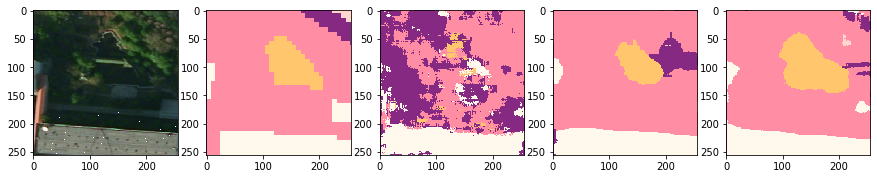

In [138]:
plt.figure(figsize=(15, 15))
plt.subplot(1,5,1)
plt.imshow(tf.keras.preprocessing.image.array_to_img(image[31]),cmap=cmap)
plt.subplot(1,5,2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[31]),cmap=cmap)
plt.subplot(1,5,3)
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask1[31]),cmap=cmap)
plt.subplot(1,5,4)
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask2[31]),cmap=cmap)
plt.subplot(1,5,5)
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask3[31]),cmap=cmap)
plt.savefig('2-31')